### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2017 ###

# Tesla's Problem: An Optimized Solution #

#### Yi Zhou (yzhou238@wisc.edu), and Roumen Guha (guha4@wisc.edu)

*****

### Table of Contents

1. [Introduction (15%)](#1.-Introduction)
1. [Mathematical Models (20%)](#2.-Mathematical-models)
1. [Solution (25%)](#3.-Solution)
    1. [Model 1](#3.A.-Model-1)
    1. [Model 2](#3.B.-Model-2)
    1. [Model 3](#3.C.-Model-3)
    1. [Helper Functions](#HELPER-FUNCTIONS)
    1. [Variable Setup](#VARIABLE-SETUP)
1. [Results and discussion (25%)](#4.-Results-and-discussion)
    1. [Model 1](#4.A.-Model-1)
        1. [Results](#4.A.a.-Results)
    1. [Model 2](#4.B.-Model-2)
        1. [Results](#4.B.a.-Results)
        2. [Pareto Tradeoff](#4.B.b.-Analysis-of-Tradeoff)
    1. [Model 3](#4.C.-Model-3)
        1. [Results](#4.C.a.-Results)
    1. [Discussion](#4.D.-Discussion)
1. [Conclusion (5%)](#5.-Conclusion)


## 1. Introduction ##

In the United States over [500,000](http://www.hybridcars.com/americans-buy-their-half-millionth-plug-in-car/) plug-in electric vehicles had been sold by August 2016. Along with this rapid growth in sales, there has also correspondingly been a rapid increase in the demand for faster charging. Conventional technologies for charging vehicles from standard wall outlets (known as Level 1 charging) take up to [8 hours](http://www.fleetcarma.com/electric-vehicle-charging-guide/) for a full charge, and usually only afford 40 miles of driving range. 

To combat this, Tesla and other electric vehicle manufacturers have released proprietary chargers which can each charge a battery to 80% in about [30 minutes](http://www.fleetcarma.com/electric-vehicle-charging-guide/). However, these stations are expensive to build, costing up to [\$270,000](https://ark-invest.com/research/supercharger-cost-comparison) per station. Tesla has reportedly spent over \$170 million to build-up this infrastructure, with plans to build [6000 stations](https://www.forbes.com/sites/alanohnsman/2017/04/24/tesla-is-doubling-its-global-charging-network-ahead-of-model-3-rollout/#6a3131e974bf) in [2017](https://www.tesla.com/supercharger) alone. In fact, after their recent [Deiselgate](http://www.reuters.com/article/us-volkswagen-emissions-idUSKBN15M20K) scandal, Volkswagen agreed to invest \$2 billion dollars to expand and improve the U.S.'s electric charger network infrastructure, and to introduce more electric vehicles into the North American market.

Planning where these stations go will be the topic of this project. 

Before we dive into the model, let's do a little more research into Tesla's circumstances. Ideally, Tesla encourages charging to about 80% of full battery capacity, and so our optimization problem is going to try to minimize the number of stations built while still allowing Tesla's vehicles to comfortably travel from one Supercharging station to another with 60% or less of their full capacity. We will also attempt to take into consideration the usage statistics of the existing charging stations, and the distribution of Tesla vehicles, since a station that is more frequently used should have other stations built nearby to minimize the wait times of the customers. 

Given the fact that the problem itself does not depend on the size of the dataset, we will solve this problem using data for __only Wisconsin__. Data on present Supercharger stations was obtained from [Tesla's website](https://www.tesla.com/supercharger) (and was recorded into the csv file labelled 'chargerPos.csv'), and population statistics for Wisconsin was obtained from [Progress Relay](http://progressrelay.com/network_010.htm). We will use data on county population to approximate a utilization rate, because such statistics are not easily obtained. We have an idea of how such data could be obtained, but it is outside the scope of this class.

Finally, we will consider proximity to wind farms (being a form of renewable energy) to be valuable to Tesla, seeing as Tesla would then pay less in electricity transfer costs, as well as have bragging rights for using green energy. 

<img src="charger_map_2017.png">
Taken from [Tesla](https://www.tesla.com/supercharger) on April 28th, 2017.

<img src="wisconsin_population_map.jpg">
Taken from [Progress Relay](http://progressrelay.com/network_010.htm) on May 3rd, 2017.

## 2. Mathematical models ##

In this version of the problem, there are a few simplifying assumptions. We first look at a single state, keeping in mind to keep the model abstract enough to generalize it for problems with more data. We maintain a matrix $locations_{i,j}$, and we maintain a vector $x_{i}$ to be the binary decision variable of whether we should build on that site. From the matrix of locations, we derive the adjacency matrix of $distances_{i,j}$ from any one location to any other. We generate n random locations within the state and attempt to pick the best N of them to build. 

We say that we can have at least N stations, where N is a parameter, and we seek to minimize the distances between chargers. The reasoning behind this being that by minimizing the distances between chargers, while being forced to build at least N chargers, we minimize the number of chargers necessary to achieve the smallest distance possible, and in this way, can decide how many chargers to build.

These models all turn out to be simple quadratic programs. They also all share a common base problem, the same decision variable, and a few common constraints.

$\textbf{Decision variable definition:}$

We define the decision variable as: 
$$
x_i = \begin{cases} 
      1 & \text{if we select $locations_{i,j}$ in the optimal set of locations to build chargers} \\
      0 & \text{otherwise}
      \end{cases}
$$

i = 1,..., n + numPresentStations

$\textbf{Standard Forms:}$


__[Model 1](#3.A.-Model-1)__: we solve the simplest version of this problem. We implement the model below: 

$$
\begin{aligned}
\underset{x \in \{0,1\}}{\text{minimize}}\qquad& \Sigma (distances * x)^2 \\
& \\
\text{subject to:}\qquad & \Sigma(x_{i}) \ge N + numPresentStations && i=1, \dots, n + numPresentStations\\
& (distances_{i, j} * x_{i}) \ge L \\
& x_{i} && \in \{0,1\} \\
& x_i = 1 && i \in [1, numPresentStations] \\
\end{aligned}
$$

+ We constrain the sum of x to be at least `N` + `numPresentStations`. This way, we say that we must have at least `N` selected stations from the randomly generated `n` locations. 
+ We constrain the first `numPresentStations` indices in `x` to be strictly equal to 1; these represent the originally present chargers.
+ We constrain the product of `distances` and `x` to each be at least `L`, so that the stations do not come too close together.
+ We minimize the sum of squares of the product of `distances * x`, aiming for stations that are not too far from one another. 

__[Model 2](#3.B.-Model-2)__: we introduce the concept of different locations having different utilization rates, depending on how densely populated an area is. We model by weighting the distances by their respective district populations, then subtracting the part of the objective function that we would like to maximize.

$$
\begin{aligned}
\underset{x \in \{0,1\}}{\text{minimize}}\qquad& \Sigma((distances * populationMatrix * x) - \lambda * (populationMatrix / totalPopWisconsin) * x)^2 \\
& \\
\text{subject to:}\qquad & \Sigma(x_{i}) \ge N + numPresentStations && i=1, \dots, n + numPresentStations \\
& (distances_{i, j} * x_{i}) \ge L \\
& x_{i} \in \{0,1\} \\
& x_i = 1 && i \in [1, numPresentStations] \\
& \lambda \in \mathbb{R_+} \\
\end{aligned}
$$

+ Only the objective function has changed between Models 1 and 2. We weighted the distances with the `populationMatrix` to simulate waiting times, and we calculate a ratio of the county population to the total Wisconsin population to as an approximation of the utilization rate of the chargers at these locations. 
+ We multiply them by the priority term $\lambda$ to be able to control where on the efficient front we want to end up. 

__[Model 3](#3.C.-Model-3)__: in this model, we decided to consider the fact that it would be preferable to Tesla to source their energy from renewable sources. To that end, we perform two tradeoffs; one for the utilization rate and the other for their proximity to windfarms. 

$$
\begin{aligned}
\underset{x \in \{0,1\}}{\text{minimize}}\qquad& \Sigma((distances * populationMatrix * x) + \beta * distBetweenWind * x - \lambda * (populationMatrix / totalPopWisconsin) * x)^2 \\
& \\
\text{subject to:}\qquad & \Sigma(x_{i}) \ge N + numPresentStations && i=1, \dots, n + numPresentStations \\
& (distances_{i, j} * x_{i}) \ge L \\
& x_{i} \in \{0,1\} \\
& x_i = 1 && i \in [1, numPresentStations] \\
& \lambda \in \mathbb{R_+} \\
& \beta \in \mathbb{R_+} \\
\end{aligned}
$$

+ In this last model, we accounted for the distances between the proposed charger locations and the wind farm locations, aiming to favor proposed locations closer to the wind farms. This is the minimizing the difference between the wind farms' locations and the selected charger positions, so it is added to the objective function. 

## 3. Solution ##

In this section, the models described above were implemented using Julia and JuMP, incorporating solvers suck as Mosek and Gurobi. Each model was embedded into a function, and had all nececessary data passed to them through arguments, making them more modular and versatile for different data. A significant effort was made to not hardcode any bounds so that the models are not limited in functionality to the state of Wisconsin. 

#### HELPER FUNCTIONS

In [1]:
# Generate n locations for the solver to decide between

function getChargerCoords(n)
    topLeft = [46.097912, -92.288938]
    topRight = [46.097912, -87.6412548]
    bottomLeft = [42.5162361, -92.288938]
    bottomRight = [42.5162361, -87.6412548]
    
    locx = (topRight[1] - bottomRight[1]) * rand(n) + bottomRight[1]
    locy = (topRight[2] - bottomLeft[2]) * rand(n) + bottomLeft[2]
    
    return (locx, locy)
end
;

In [2]:
# Calculate the Euclidean distance between the desired locations

function calcDistances(desiredLocations, n, numPresentStations)
    distances = zeros(n + numPresentStations, n + numPresentStations)
    
    for i in 1:(numPresentStations + n)
        for j in 1:(numPresentStations + n)
            distances[i,j] = sqrt((desiredLocations[i, 1] - desiredLocations[j, 1])^2 + (desiredLocations[i, 2] - desiredLocations[j, 2])^2)
        end
    end
    
    return distances
end
;

In [3]:
# Funtion takes in a value for latitude and longitude, then returns the population that belongs to that district. 
# Wisconsin's counties were broken up into four districts; by doing this we could easily consider different utilization rates
# without having to tediously set constraints for every county's borders.

function getDistrictPopulation(a, b)
    
    if (45.243522352 <= a <= 46.097912 && -92.288938 <= b <= -89.927123)
        utilization = (poplDict[:Douglas] + poplDict[:Bayfield] + poplDict[:Ashland] + poplDict[:Iron] + poplDict[:Burnett]
            + poplDict[:Washburn] + poplDict[:Sawyer] + poplDict[:Price] + poplDict[:Polk] + poplDict[:Barron] + poplDict[:Rusk])
    end
    if (42.5162361 <= a <= 45.243522352 && -92.288938 <= b <= -89.927123)
        utilization = (poplDict[:StCroix] + poplDict[:Dunn]  + poplDict[:Chippewa] + poplDict[:Taylor] + poplDict[:Pierce]
            + poplDict[:EauClaire] + poplDict[:Clark] + poplDict[:Pepin] + poplDict[:Buffalo] + poplDict[:Trempealeau]
            + poplDict[:Jackson] + poplDict[:LaCrosse] + poplDict[:Monroe] + poplDict[:Vernon] + poplDict[:Crawford]
            + poplDict[:Richland] + poplDict[:Grant] + poplDict[:Iowa] + poplDict[:Lafayette])
    end
    if (44.681293 <= a <= 46.097912 && -89.927123 <= b <= -87.6412548)
        utilization = (poplDict[:Vilas] + poplDict[:Forest] + poplDict[:Oneida] + poplDict[:Marinette] + poplDict[:Lincoln]
            + poplDict[:Langlade] + poplDict[:Oconto] + poplDict[:Menominee] + poplDict[:Marathon] + poplDict[:Shawano]
            + poplDict[:Door])
    end
    if (42.5162361 <= a <= 44.681293 && -89.927123 <= b <= -87.6412548)
         utilization = (poplDict[:Wood]+ poplDict[:Portage]+ poplDict[:Waupaca] + poplDict[:Outagamie]+ poplDict[:Brown] 
            + poplDict[:Brown]+ poplDict[:Kewaunee] + poplDict[:Juneau] + poplDict[:Adams] + poplDict[:Waushara] 
            + poplDict[:Winnebago] + poplDict[:Calumet] + poplDict[:Manitowoc] + poplDict[:Sauk] + poplDict[:Columbia]
            + poplDict[:Marquette] + poplDict[:GreenLake] + poplDict[:FondDuLac] + poplDict[:Shebiygan] + poplDict[:Dodge]
            + poplDict[:Washington] + poplDict[:Ozaukee] + poplDict[:Dane] + poplDict[:Jefferson] + poplDict[:Waukesha]
            + poplDict[:Milwaukee] + poplDict[:Green] + poplDict[:Rock] + poplDict[:Walworth] + poplDict[:Racine]
            + poplDict[:Kenosha])
    end
    
    return utilization
end
;

#### VARIABLE SETUP

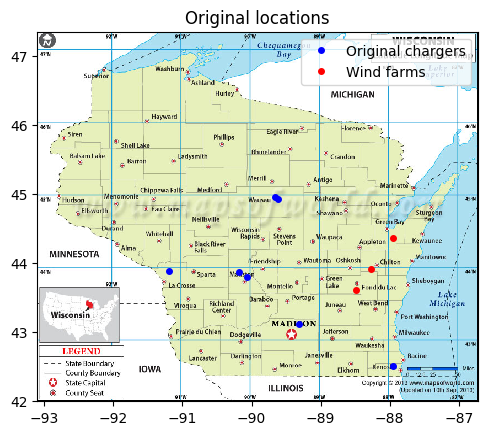

In [4]:
using PyPlot

rawChargerPos = readcsv("chargerPos.csv")
currChargerLocations = rawChargerPos[:, 2:end] # locations of chargers in WI that have already been built
numPresentStations = length(currChargerLocations[:, 1])

rawWindFarmPos = readcsv("WindFarmLocations.csv")
currWindFarmPos = rawWindFarmPos[:, 2:end] # locations of wind farms in Wisconsin
numWindFarms = length(currWindFarmPos[:, 1])

wisconsin = imread("wisconsin-lat-long-map.png") # a map of Wisconsin on which to plot our points
imshow(wisconsin, extent=[-93.1, -86.72, 42, 47.35])

plot(currChargerLocations[:, 2], currChargerLocations[:, 1], "b.", markersize = 8)
plot(currWindFarmPos[:, 2], currWindFarmPos[:, 1], "r.", markersize = 8)
legend(["Original chargers", "Wind farms"])
title("Original locations")

n = 50 # number of randomly generated possible stations
N = 5 # number of desired stations

L_0 = 0.1
L = L_0 # distance paramater - found through sensitivity analysis

c_0 = 0.0005
c = c_0 # conversion rate for population

(locx, locy) = getChargerCoords(n) # Get n randomly generated points to select N optimal points from later
desiredLocations = [locx locy]
locations = [currChargerLocations; desiredLocations]
distances = calcDistances(locations, n, numPresentStations) # Calulate the distances between these points
locations2 = [currWindFarmPos; desiredLocations]
distances2 = calcDistances(locations2, n, numWindFarms)[1:numWindFarms, (numWindFarms + 1):end]

counties = [:Milwaukee, :Dane, :Waukesha, :Brown, :Racine, :Outagamie, :Winnebago, :Kenosha,
    :Rock, :Marathon, :Washington, :Shebiygan, :LaCrosse, :FondDuLac, :Walworth, :EauClaire, 
    :Dodge, :Ozaukee, :Manitowoc, :Jefferson, :StCroix, :Wood, :Portage, :Chippewa, :Sauk,
    :Columbia, :Waupaca, :Grant, :Barron, :Calumet, :Polk, :Marinette, :Douglas, :Monroe,
    :Dunn, :Shawano, :Pierce, :Oconto, :Oneida, :Green, :Clark, :Lincoln, :Door ,:Vernon,
    :Trempealeau, :Juneau, :Waushara, :Iowa, :Vilas, :Adams, :Langlade, :Kewaunee, :Jackson,
    :Taylor, :GreenLake, :Richland, :Crawford, :Sawyer, :Washburn, :Ashland, :Burnett,
    :Lafayette, :Price, :Bayfield, :Rusk, :Marquette, :Buffalo,:Forest, :Pepin, :Iron,
    :Florence, :Menominee]

population = [937324, 468514, 381651, 244764, 195113, 173773, 164703, 161370, 159530, 134028, 
            129316, 117045, 111791, 101174, 100672, 98000, 89225, 86697, 84603, 80411, 79020, 
            76839, 69959, 61604, 60673, 55636, 53773, 51037, 47551, 46031, 45611, 44646, 44096, 
            43838, 43118, 42413, 40235, 38958, 38600, 36262, 34479, 30562, 30043, 29530, 28119, 
            27177, 25215, 24130, 22545, 21645, 21517, 21198, 20080, 20049, 19446, 18208, 17553, 
            17542, 17403, 16879, 16749, 16317, 16069, 15990, 15627, 15319, 14183, 10329, 7714, 
            7002, 5295, 4606]

poplDict = Dict(zip(counties, population)) # dictionary of each Wisconsin county's population

totalPopWisconsin = sum(population)

;

### 3.A. Model 1

In [5]:
using JuMP, Gurobi, Mosek

function model1()
    m = Model(solver = GurobiSolver(OutputFlag = 0))
    
    # The binary vector of whether the given locations were selected for building a Supercharger station
    @variable(m, x[1:n + numPresentStations], Bin)

    # The initially present stations cannot be removed
    for i in 1:numPresentStations
        @constraint(m, x[i, 1] == 1)
    end

    # We must have at least N more Supercharger stations
    @constraint(m, sum(x) >= N + numPresentStations)

    # Set a minimum distance between chosen stations, so that the stations will not be too close together
    @constraint(m, distances * x .>= L) 

    @expression(m, dist, sum((distances * x).^2))
    
    @objective(m, Min, dist)

    solve(m)
    xopt = getvalue(x)
    return xopt
end;

### 3.B. Model 2

In [6]:
using JuMP, Gurobi, Mosek
function model2(λ)

    m = Model(solver = GurobiSolver(OutputFlag = 0))

    @variable(m, x[1:n + numPresentStations], Bin)

    for i in 1:numPresentStations
        @constraint(m, x[i] == 1)
    end
    
    districtPopn = []
    for i in 1:n + numPresentStations
        push!(districtPopn, getDistrictPopulation(locations[i, 1], locations[i, 2]))
    end

    @constraint(m, sum(x) >= N + numPresentStations)

    populationM = zeros(n + numPresentStations, n + numPresentStations)
    for i in 1:n+numPresentStations
        populationM[i, i] = districtPopn[i]
    end

    @constraint(m, distances * x .>= L)
    
    @expression(m, waitingTime, distances * (c * populationM * x))
    @expression(m, utilizationRates, (populationM ./ totalPopWisconsin) * x)

    # Objective function is a tradeoff between the waiting time and the utilization rates of the charging stations
    @objective(m, Min, sum((waitingTime - λ * (utilizationRates)).^2))
    
    solve(m)
    xopt = getvalue(x)
    wopt = distances * (populationM * xopt)
    return (xopt, sum(wopt), sum(populationM ./ totalPopWisconsin * xopt))
end;

### 3.C. Model 3

In [7]:
using JuMP, Gurobi, Mosek
function model3(λ, β)

    m = Model(solver = GurobiSolver(OutputFlag = 0))
    
    @variable(m, x[1:n+numPresentStations], Bin)

    for i in 1:numPresentStations
        @constraint(m, x[i] == 1)
    end

    districtPopn = []
    for i in 1:n + numPresentStations
        push!(districtPopn, getDistrictPopulation(locations[i, 1], locations[i, 2]))
    end

    @constraint(m, sum(x) >= N + numPresentStations)

    populationM = zeros(n + numPresentStations, n + numPresentStations)
    distBetweenWind = zeros(n + numPresentStations, n + numPresentStations)
    for i in 1:n + numPresentStations
        populationM[i, i] = districtPopn[i]
    end
    for i in (numPresentStations + 1):(n + numPresentStations)
        distBetweenWind[i, i] = sum(distances2[j, i - numPresentStations] for j in 1:numWindFarms)
    end
 
    @constraint(m, distances * x .>= L)

    @expression(m, waitingTime, distances * (c * populationM * x))
    @expression(m, utilizationRates, (populationM ./ totalPopWisconsin) * x)
    
    # Objective function is a tradeoff between the waiting time, the distance to wind farms, 
    # and the utilization rates of the charging stations
    @objective(m, Min, sum((waitingTime + β * (distBetweenWind * x) - λ * (utilizationRates)).^2))

    solve(m)
    
    xopt = getvalue(x)
    return (xopt, sum(distances * (populationM * xopt)), sum(distBetweenWind * xopt), sum(populationM ./ totalPopWisconsin * xopt))
end;

## 4. Results and discussion

*__Note:__ In this section, the plot labels aren't always correct. Refer to the code above plots to determine what the colors represent.*

In this section, we simply go through and produce the plots from the model implementations above. At the end of this section, we briefly discuss these models and their results. 

### 4.A. Model 1

#### 4.A.a. Results

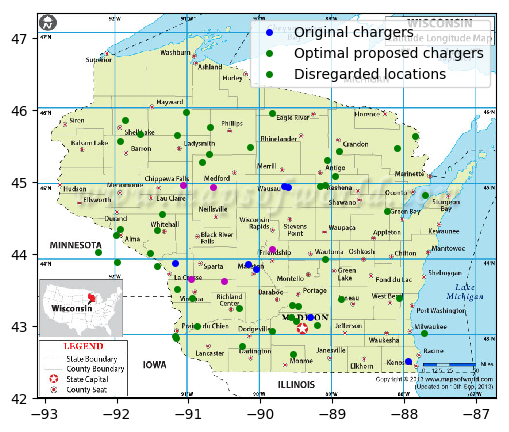

In [8]:
using PyPlot

y = locations[:, 1]
x = locations[:, 2]

figure(figsize = (6, 5))
imshow(wisconsin, extent=[-93.1, -86.72, 42, 47.35])
plot(x[1:numPresentStations], y[1:numPresentStations], "b.", markersize = 8) # Plot the original charging stations
xopt1 = model1()

for i in (numPresentStations + 1):(n + numPresentStations)
    if (xopt1[i] > 0 )
        plot(locations[i, 2], locations[i, 1], "m.", markersize = 8) # Plot the optimal charging stations
    elseif (xopt1[i] < 1)
        plot(locations[i, 2], locations[i, 1], "g.", markersize = 8) # Plot the proposed charging stations
    end
end

legend(["Original chargers", "Optimal proposed chargers", "Disregarded locations"])
;

### 4.B. Model 2

#### 4.B.a. Results

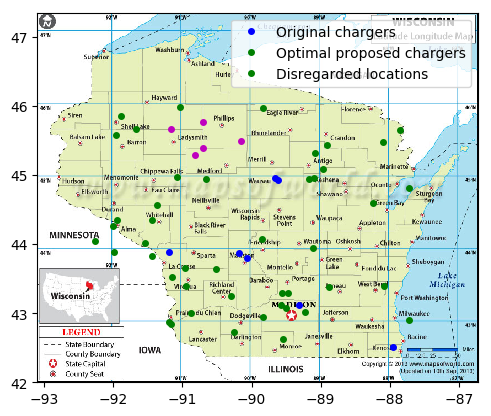

In [9]:
using PyPlot

x = locations[:, 2]
y = locations[:, 1]

λ = 5000 # increase this to weigh utilization rates more heavily

imshow(wisconsin, extent=[-93.1, -86.72, 42, 47.35])
plot(x[1:numPresentStations], y[1:numPresentStations], "b.", markersize = 8) # Plot the original charging stations
(xopt2, a, b) = model2(λ)

for i in (numPresentStations + 1):(n + numPresentStations)
    if (xopt2[i] > 0)
        plot(locations[i, 2], locations[i, 1], "m.", markersize = 8) # if point is optimal
    elseif (xopt2[i] < 1)
        plot(locations[i, 2], locations[i, 1], "g.", markersize = 8) # if point is not optimal
    end
end
legend(["Original chargers", "Optimal proposed chargers", "Disregarded locations"])
;

#### 4.B.b. Analysis of Tradeoff

*__NOTE:__ MIGHT NEED TO BE RE-RUN AFTER EVERYTHING ELSE HAS BEEN RUN*

Here, we investigate a tradeoff between the utilization rate and the waiting time of a charger as we increase λ.

Since we made the model functions so modular, we can simply call it here to enumerate through all the results. We use an enormous log spacing to make sure we get a full range of results. 

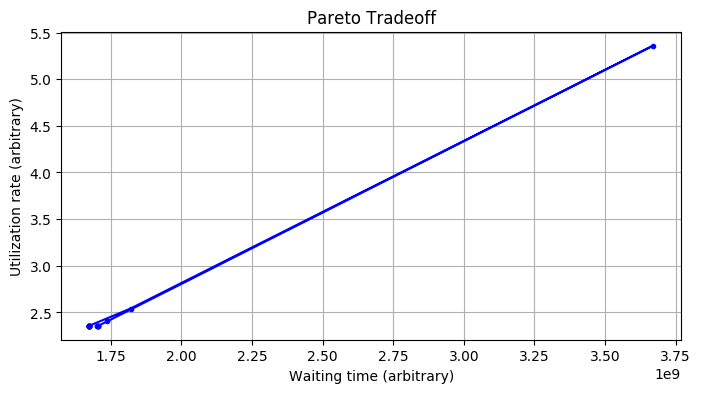

In [10]:
using PyPlot

Npts = 20
J1 = zeros(Npts)
J2 = zeros(Npts)
for (i, λ) in enumerate(logspace(0, 9, Npts))
    (xopt, J1[i], J2[i]) = model2(λ)
end;

figure(figsize = (8, 4))
plot(J1, J2, "b.-")
grid()
ylabel("Utilization rate (arbitrary)")
xlabel("Waiting time (arbitrary)")
title("Pareto Tradeoff")
;

### 4.C. Model 3

#### 4.C.a. Results

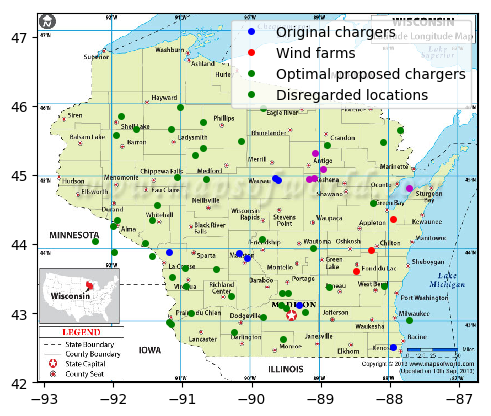

In [11]:
using PyPlot

x = locations[:, 2]
y = locations[:, 1]
x1 = locations2[1:numWindFarms, 2]
y1 = locations2[1:numWindFarms, 1]

λ = 50 # increase this to weigh utilization rates more heavily
β = 5000 # increase this to weigh proximity to wind farms more heavily

imshow(wisconsin, extent=[-93.1, -86.72, 42, 47.35])
plot(x[1:numPresentStations], y[1:numPresentStations], "b.", markersize = 8) # Plot the original charging stations
plot(x1, y1, "r.", markersize = 8) # Plot the wind farms
(xopt3, a, b, c) = model3(λ, β)

for i in (numPresentStations + 1):(n + numPresentStations)
    if (xopt3[i] > 0)
        plot(locations[i, 2], locations[i, 1], "m.", markersize = 8) # if point is optimal
    elseif (xopt3[i] < 1)
        plot(locations[i, 2], locations[i, 1], "g.", markersize = 8) # if point is not optimal
    end
end
legend(["Original chargers", "Wind farms", "Optimal proposed chargers", "Disregarded locations"])
;

### 4.D. Discussion
__Limitations and Considerations for Improvements__

*To get a better feel for how the models work, try changing the values of $\lambda$, $\beta$ in the code blocks above.*

The optimizer models provide an optimal choice of N charging stations for three different considerations, finally developing into Model 3, which considers both distance from wind farms, as well as the (approximated) utilization rates of chargers in certain areas, based upon county populations. Making `n` larger will get better results, but this also reduces the computational tractability of the problem quite significantly. 

Also, given the fact that these points were generated randomly, some were generated outside of the Wisconsin border, and others were generated on top of large water bodies, something that given more time could have been incorporated into the model. So far, this model serves to give a good idea of where to start looking to build chargers. It is not a complete solution, as other factors (such as localized labor and maintenance costs, costs due to expedited  wear and tear through more sustained usage, or simply land costs) were not considered. 

Another consideration to make is that wind power is not the only form of favorable renewable energy that Tesla might prefer; for example, solar power is becoming far more common in the Midwest as of late, and these locations could easily be included in the spreadsheet that was imported at the beginning of the project. However, some modifications to the model would be required as Tesla may prefer one source of renewable energy over another, and this weighting would have to be implemented. 

Moreover, this is just one way that Tesla could choose to solve their charging network expansion problem. Another solution they considered was to have hot swappable batteries that their customers could pay for on a per-use basis, in which case it would be a combinatorial optimization problem.

## 5. Conclusion ##


This report presents three models used to optimize the locations of Tesla Supercharger stations. We examined a few of the different aspects and possible tradeoffs involved with building such electric charging stations in the state of Wisconsin. One thing to note, however, is that the model is only as good as the data, and so are bounded by the rule of [GIGO stability](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out). In the real world, there are peak periods associated with the seasons, battery capacity is diminished in cold climates like that of Wisconsin, and the distribution of Tesla vehicles is not uniform. 

Nonetheless, we can draw the following conclusions from this report: 

1. While it is possible to successfully model this problem as a Quadratic Program, the memory requirement rapidly increases with an increase in the number of sample points, which rapidly leads to intractability. 
2. The tradeoffs involved with the models described here (and their derivatives) will have their tradeoff curves be easy to control and explore more finely, so at least for smaller scale models such as these, it is better to get a feel for your options. 

Future work will involve incorporating the other aspects of this project: for example, we could look into other forms of renewable energy such as solar power, wave power, geothermal power, and hydroelectric power. We could further our solution into the combinatorial optimization problem of hot swappable high-voltage batteries, or simply improve our output by improving the quality of our data by mining Google Maps for Supercharger usage statistics.

Furthermore, to extend these models to work for larger areas, such as the entire North American continent, we will have to reformulate how distances are calculated. Presently they are calculated as Euclidean distances using the latitudes and longitudes as their coordinates, however this is clearly not correct when dealing with large areas due to the curvature of the planet. We could instead apply [Vincenty's formulae](https://en.wikipedia.org/wiki/Vincenty%27s_formulae) which would get us much more accurate distances. More advanced techniques would still have to be considered however, becuase the direct distance between two points is not necessarily a possible path to take. 